In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [2]:
df = pd.read_csv('../input/world-data-covid/time_series_19-covid-Confirmed.csv')
df.head()
df_future=pd.read_csv("../input/world-data-covid/Book1.csv",index_col="Date",parse_dates=True)
li=df_future["Cases"].values


In [3]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,...,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,...,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,...,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,...,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,91,91,91,91,91


In [4]:
df.isnull().sum().sum()

0

In [5]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

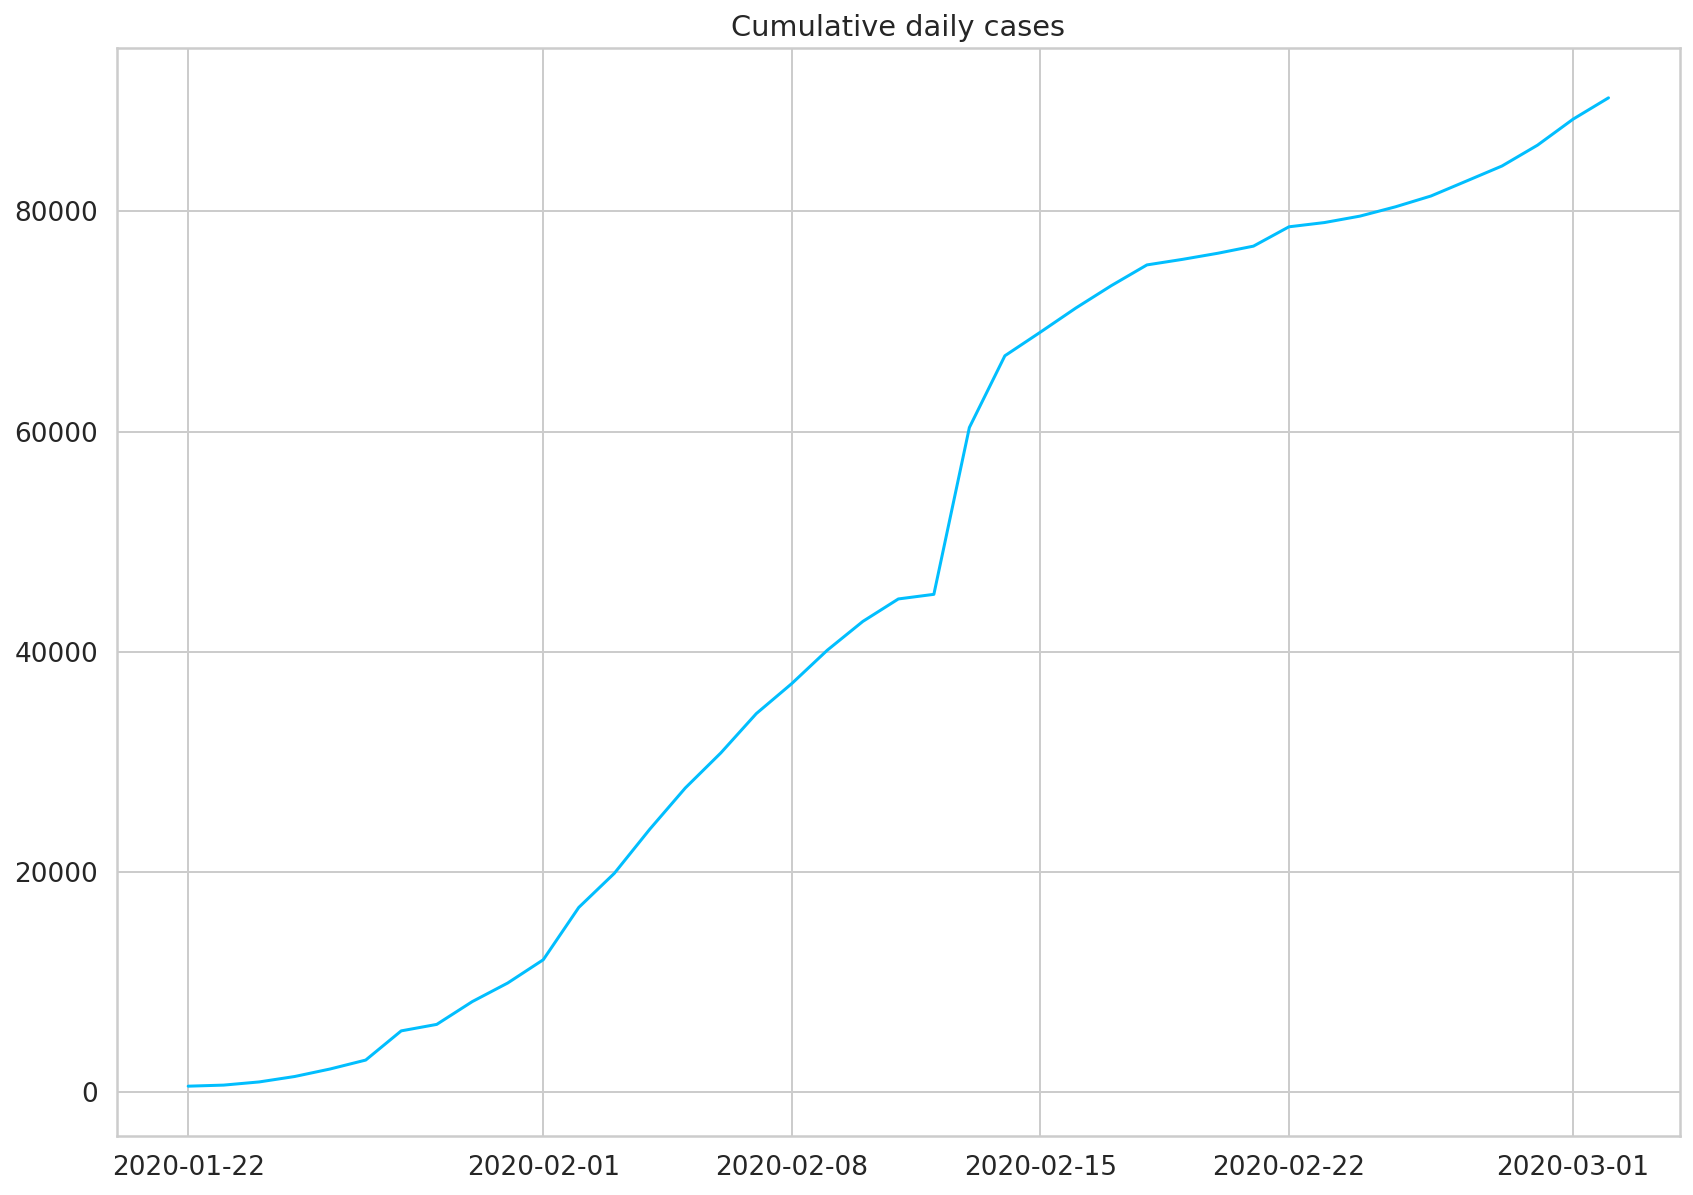

In [6]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [7]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

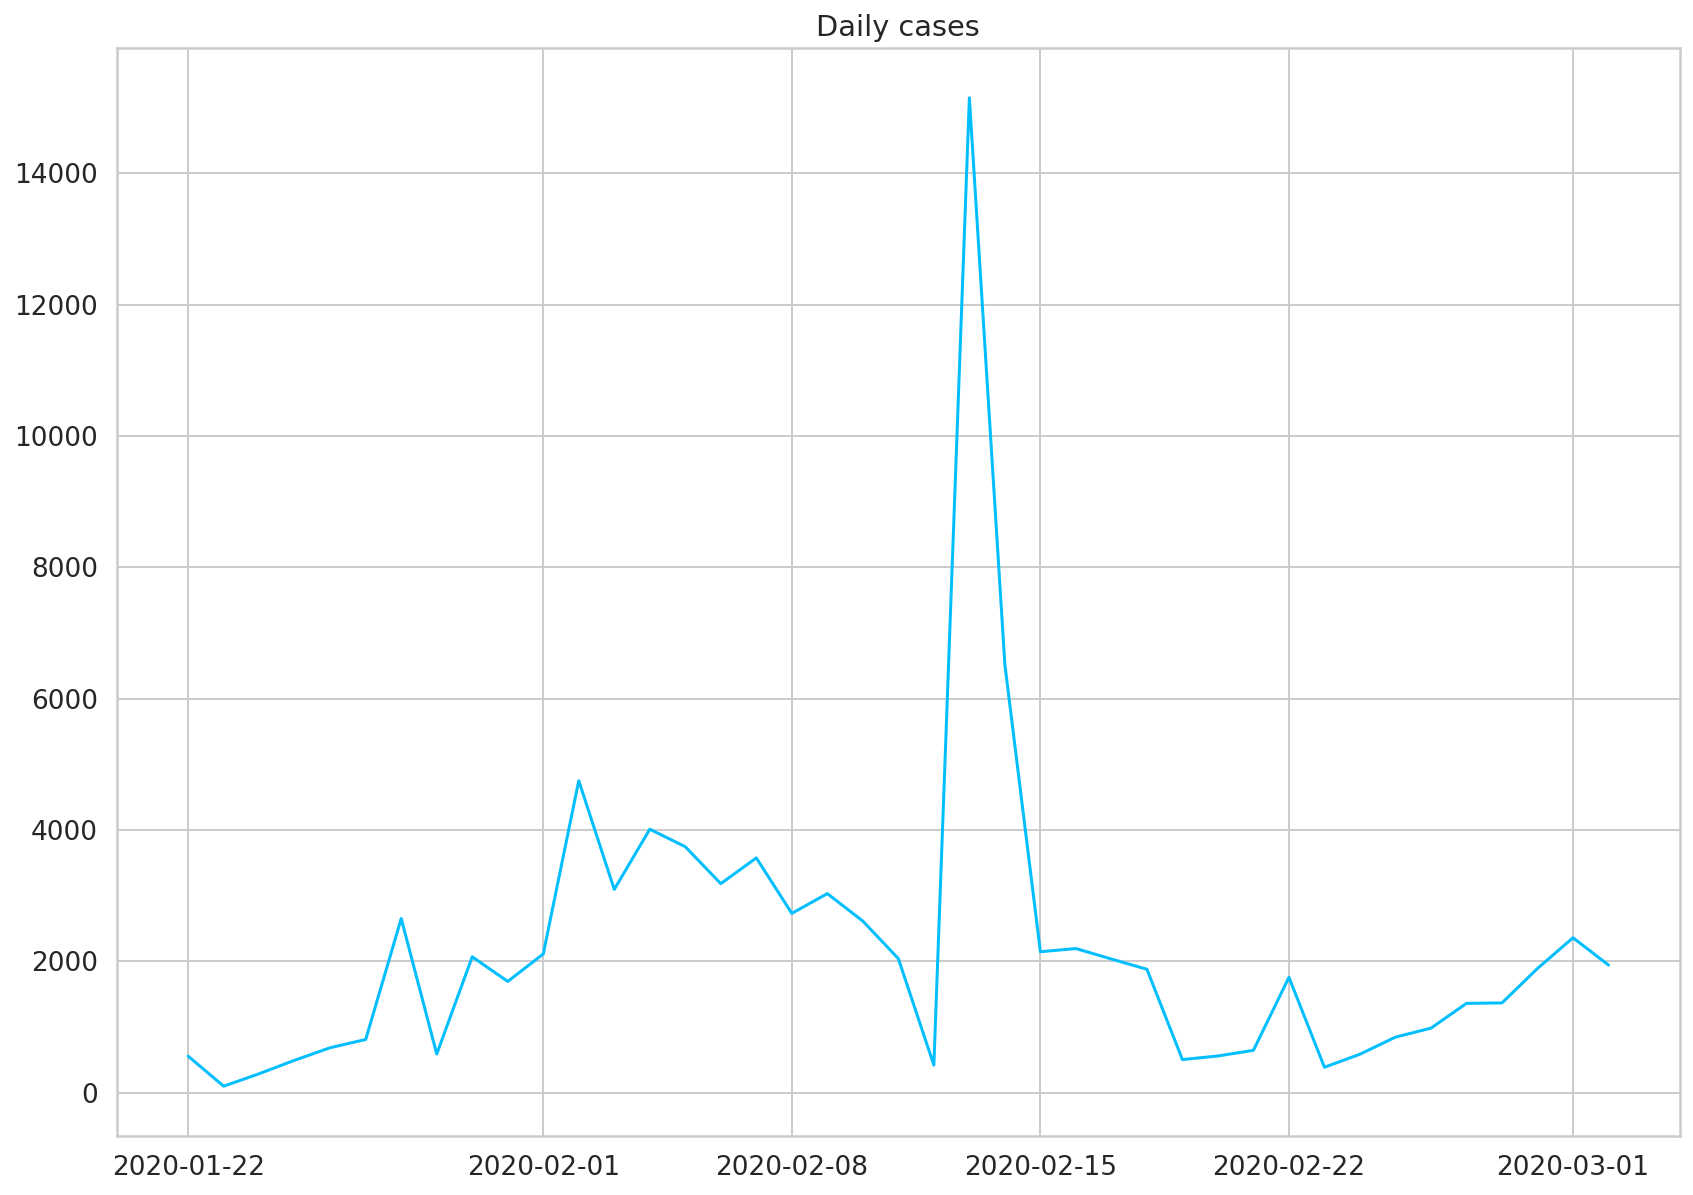

In [8]:
plt.plot(daily_cases)
plt.title("Daily cases");

In [9]:
daily_cases.shape

(41,)

In [10]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(27,)

In [11]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [12]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [13]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [14]:
X_train.shape

torch.Size([21, 5, 1])

In [15]:
X_train[:2]

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]]])

In [16]:
y_train.shape

torch.Size([21, 1])

In [17]:
y_train[:2]

tensor([[0.0472],
        [0.1696]])

In [18]:
train_data[:10]

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007]])

In [19]:
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [20]:
def train_model(
  model, 
  train_data, 
  train_labels, 
  test_data=None, 
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [21]:
model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  X_train, 
  y_train, 
  X_test, 
  y_test
)

Epoch 0 train loss: 1.6297188997268677 test loss: 0.041186608374118805
Epoch 10 train loss: 0.8466923832893372 test loss: 0.12416433542966843
Epoch 20 train loss: 0.821993350982666 test loss: 0.143820121884346
Epoch 30 train loss: 0.8200693130493164 test loss: 0.2190694659948349
Epoch 40 train loss: 0.810839056968689 test loss: 0.1797715276479721
Epoch 50 train loss: 0.7957305312156677 test loss: 0.19855864346027374


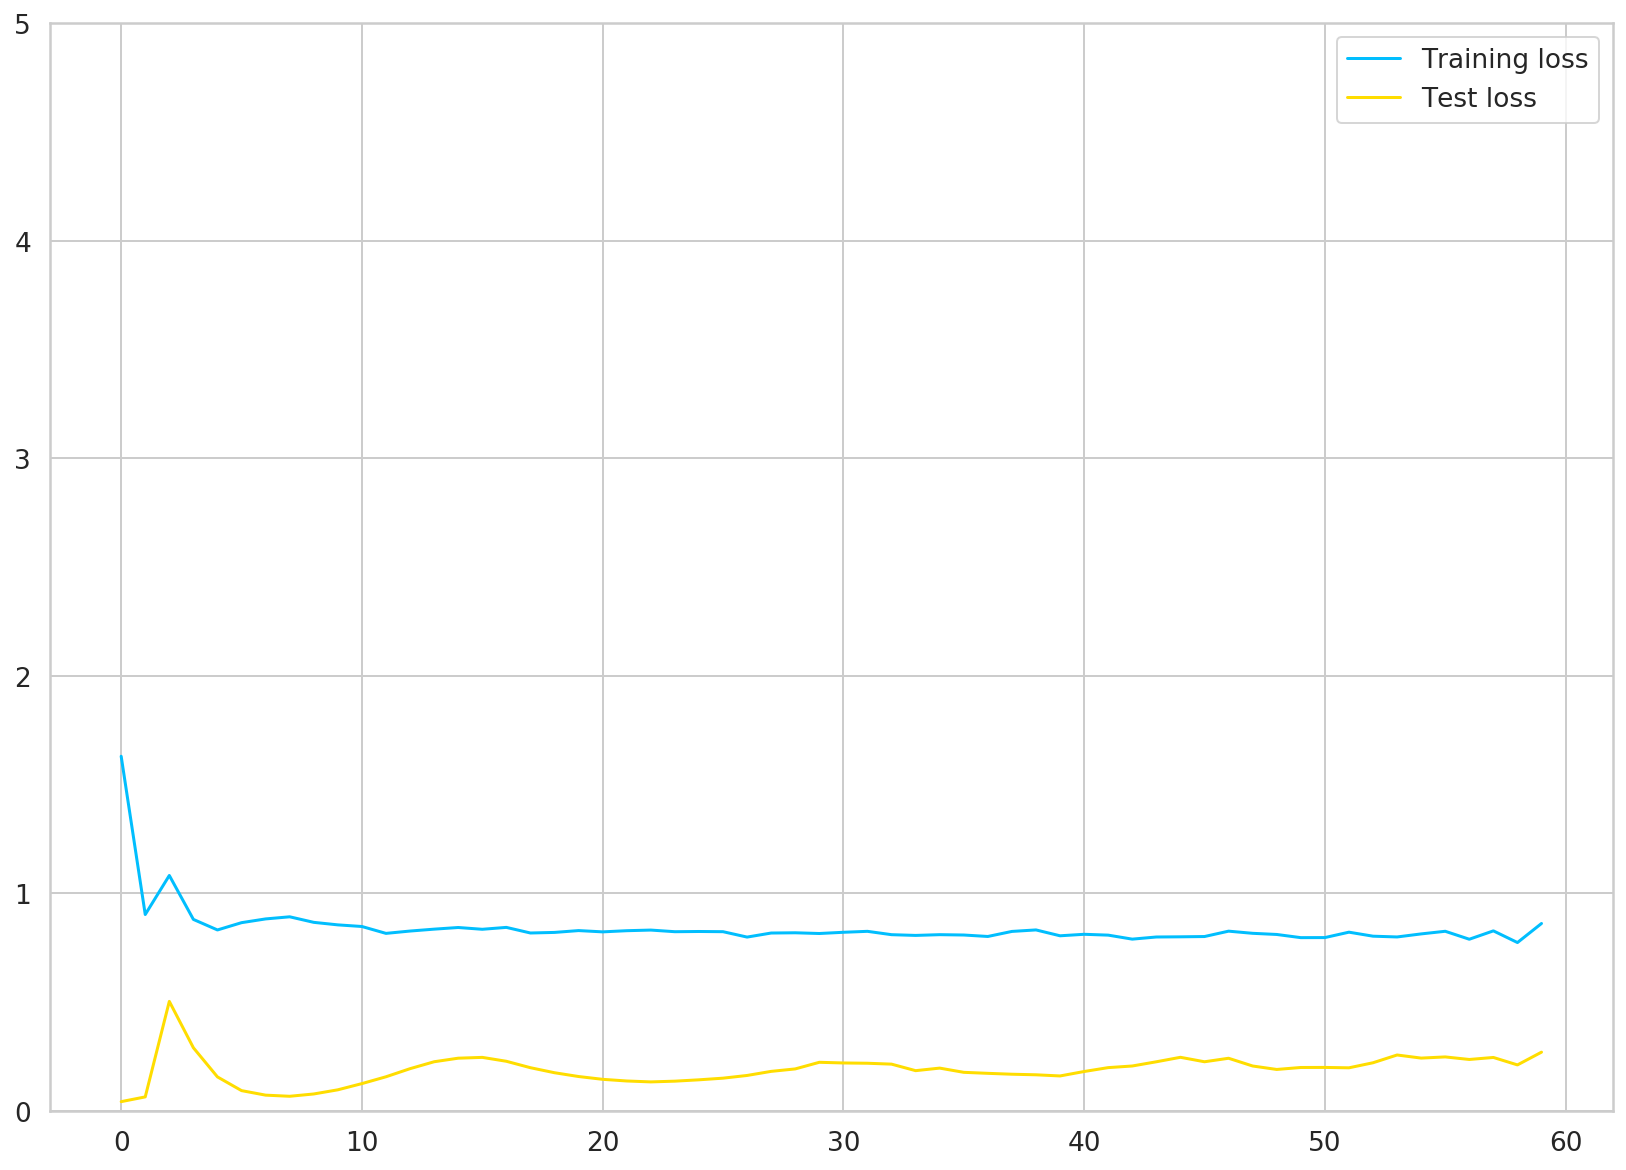

In [22]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 5))
plt.legend();

In [23]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [24]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

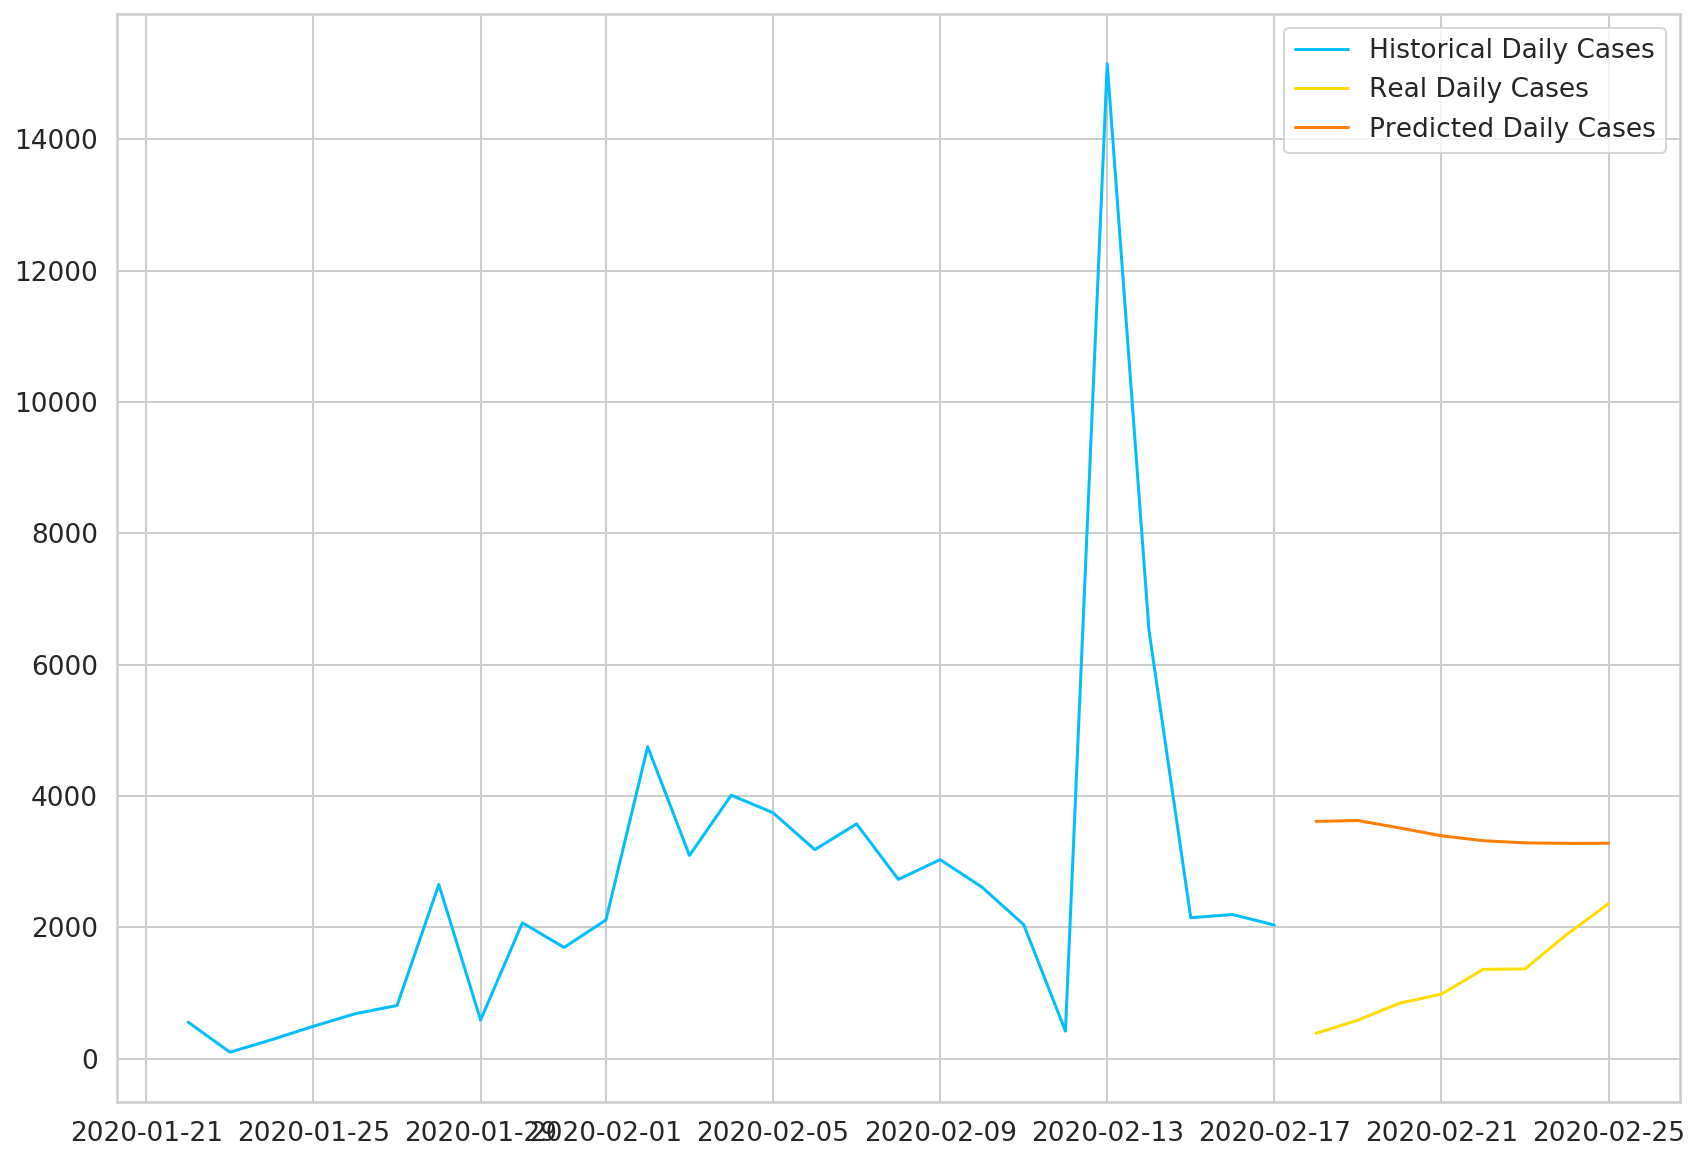

In [25]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

In [26]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(41, 1)

In [27]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 1.9441421031951904
Epoch 10 train loss: 0.8385429382324219
Epoch 20 train loss: 0.8256546854972839
Epoch 30 train loss: 0.8023680448532104
Epoch 40 train loss: 0.8125611543655396
Epoch 50 train loss: 0.8225001692771912


In [28]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [29]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [30]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

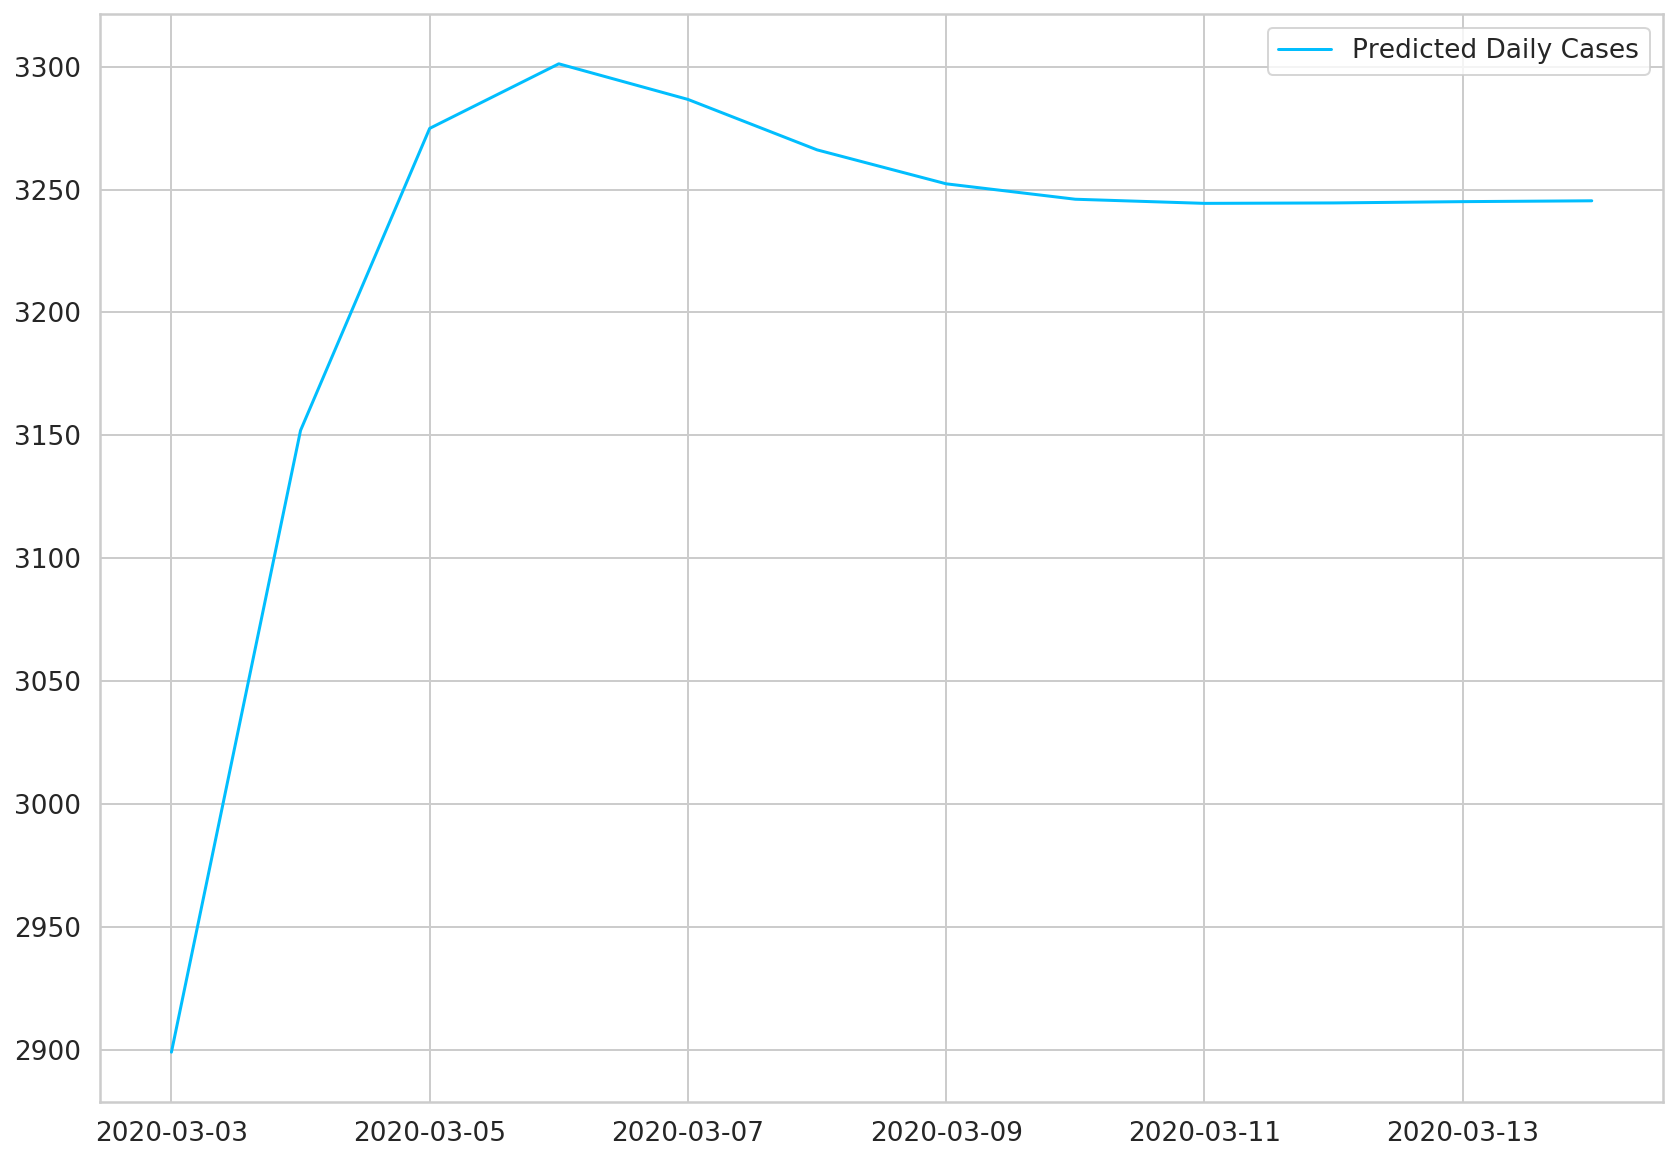

In [31]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [32]:
predicted_cases

2020-03-03    2898.944135
2020-03-04    3151.961545
2020-03-05    3274.883845
2020-03-06    3301.160231
2020-03-07    3286.675117
2020-03-08    3266.144336
2020-03-09    3252.330216
2020-03-10    3246.052213
2020-03-11    3244.370244
2020-03-12    3244.547411
2020-03-13    3245.073531
2020-03-14    3245.416653
Freq: D, dtype: float64

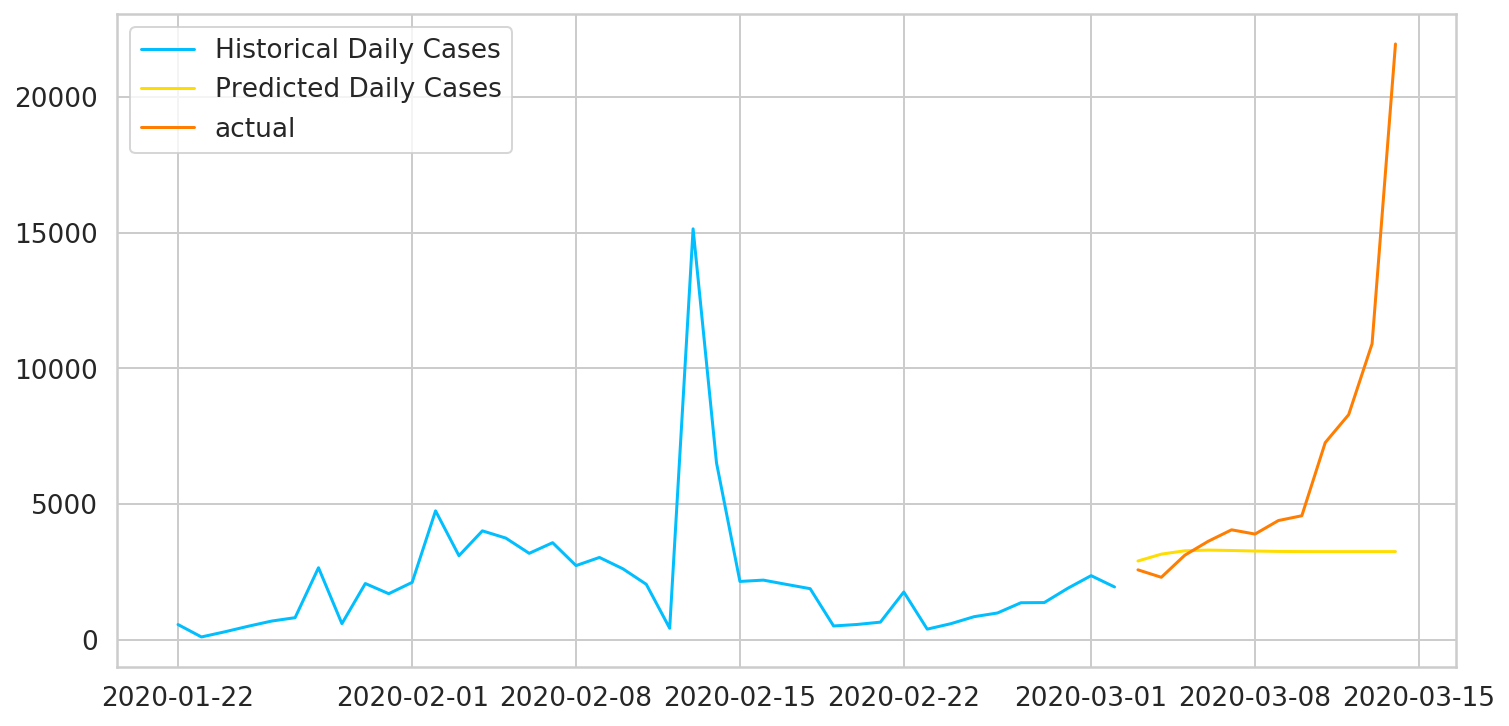

In [33]:
plt.figure(figsize=(12,6))
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.plot(df_future,label="actual")
plt.legend();